#Import Library

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler, SubsetRandomSampler,Dataset)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
import os
import warnings
from openpyxl import load_workbook
from openpyxl import Workbook
from sklearn import tree
warnings.filterwarnings("ignore")

#Preprocessing Data

In [ ]:
files = [f for f in os.listdir('.') if os.path.isfile(f)]

In [ ]:
def prepare_data(seqs):
    max_len = 0

    #Mapping huruf menjadi angka
    voc2ind = {voc:ind for ind,voc in enumerate(['<pad>', '<unk>', 'A', 'T', 'C', 'G','N','X'])}
    
    i = len(voc2ind)
    
    tokenized_seqs = []
    for seq in seqs:
        tokenized_seq = []
        for e in seq:
            # Mengubah setiap huruf menjadi huruf besar
            seq = seq.upper()
            # Jika ditemukan huruf baru dalam sequence, akan ditambah ke dalam mapping
            if not e in voc2ind:
                voc2ind[e] = i
                i += 1
            # voc2ind[e] digunakan untuk mapping, misalnya yang ditemukan huruf A
            # maka akan diubah menjadi angka 2 dan ditambahkan ke dalam list tokenized_seq    
            tokenized_seq.append(voc2ind[e])
        # Jika semua huruf dalam 1 sequence telah diubah maka list tokenized_seq
        # akan ditambahkan ke dalam list tokenized seqs
        tokenized_seqs.append(tokenized_seq)
        
    return tokenized_seqs, voc2ind

def prepare_labels(labels):
    tokenized_labels = []
    label2token = {}
    i = 0
    for label in labels:
        # Mencari unique label yang ada pada dataset
        if not label in label2token:
            label2token[label] = i
            i += 1
        # Mengubah label ke dalam bentuk angka dan memasukkannya ke dalam tokenized_labels
        tokenized_labels.append(label2token[label])
    return tokenized_labels, label2token

def pad(tokenized_seqs, voc2ind):
    padded_seqs = []
    max_len = 0

    # Mencari sequence terpanjang yg ada pada dataset
    for seq in tokenized_seqs:
        max_len = max(len(seq), max_len)
    
    # Jika ada yang panjangnya kurang dari maximal length, maka akan diisi dengan 0
    for seq in tokenized_seqs:
        padded_seq = seq + [voc2ind['<pad>']] * (max_len - len(seq))
        padded_seqs.append(padded_seq)
        
    return np.array(padded_seqs, dtype=np.float32)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=128):
  
    # Mengubah tipe data menjadi tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Menggabungkan fitur dan label pada data train menjadi 1 tensor dataset
    train_data = TensorDataset(train_inputs, train_labels)
    # Membuat sampler pada data train dengan metode random sampler
    train_sampler = RandomSampler(train_data)
    # Membuat data train yang bisa digunakan oleh model deep learning menggunakan
    # tensor dataset dan sampler pada data train yang telah dibuat
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Menggabungkan fitur dan label pada data validasi menjadi 1 tensor dataset
    val_data = TensorDataset(val_inputs, val_labels)
    # Membuat sampler pada data validasi dengan metode random sampler
    val_sampler = SequentialSampler(val_data)
    # Membuat data validasi yang bisa digunakan oleh model deep learning menggunakan
    # tensor dataset dan sampler pada data validasi yang telah dibuat
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

def preprocess(filenames, test_size = 0.2):
  # Membaca file excel dan membuat dataframe dengan file excel tersebut
  df = pd.read_excel(filenames)
  # Menghapus kolom '1'
  df = df[df.columns.drop(list(df.filter(regex='1')))]
  # Mengubah nama kolom terakhir menjadi Class
  df.set_axis([*df.columns[:-1], 'Class'], axis=1, inplace=True)
  # Menyisakan kolom GenBarcode dan kolom Class
  df = df[['GenBarcode','Class']]
  # Mengubah nama kolom GenBarcode menjadi Gene
  df.rename(columns={'GenBarcode':'Gene'},inplace=True)
  # Menghapus kolom dengan Class 'Missing' dan 'Undetermined'
  df = df.drop(df[df.Class == 'Missing'].index)
  df = df.drop(df[df.Class == 'Undetermined'].index)
  # Menghapus kolom yang memiliki value NaN
  df.dropna(inplace=True)
  # Mengambil nilai dari kolom Gene dan Class
  seqs = df.Gene.values
  labels = df.Class.values

  # Mengubah huruf dalam sequence DNA ke dalam bentuk angka
  tokenized_seqs, voc2ind = prepare_data(seqs)
  # Mengisi sequence yang kosong dengan 0 
  tokenized_seqs = pad(tokenized_seqs, voc2ind)
  # Mengubah label ke dalam bentuk angka (0 dan 1)
  tokenized_labels, label2token = prepare_labels(labels)
  # Membagi dataset menjadi data train dan data test dengan proporsi 80% data train dan 20% data test
  train_inputs, test_inputs, train_labels, test_labels = train_test_split(
      tokenized_seqs, tokenized_labels, test_size=test_size, random_state=42, stratify=tokenized_labels)
  # Mengubah data train dan data test ke dalam bentuk dataset yang bisa digunakan oleh model deep learning
  train_dataloader, test_dataloader = data_loader(train_inputs, test_inputs, 
                                                  train_labels, test_labels, 
                                                  batch_size=64)
  return tokenized_seqs, voc2ind, tokenized_labels, train_dataloader, test_dataloader

In [ ]:
class dataset(Dataset):
  def __init__(self,x,y):
    # Mengubah data ke dalam bentuk tensor
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    # Mencari panjang sequence
    self.length = self.x.shape[0]

  def __getitem__(self,idx):
    # Mengambil data pada index tertentu
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

#Deep Learning

##Build Model

###BiLSTM

In [ ]:
class BiLSTM(nn.Module):
  
    def __init__(self, vocab_size,input_dim, hidden_dim, num_layers, output_dim):
        super(BiLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = input_dim
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Pada BiLSTM parameter bidirectional pada kelas LSTM bernilai True
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional = True)
        # Pada BiLSTM hidden state pada fully connected layer dikali 2 (karena pada BiLSTM terdapat forward layer dan backward layer)
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.tensor(x).to(torch.int64)
        x = self.encoder(x)
        # Pada BiLSTM, LSTM layer pada hidden state dan cell state dikali 2
        h0 = torch.zeros(self.num_layers*2, x.size(0),self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers*2, x.size(0),self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = torch.sigmoid(self.fc(out))
        out = out[:, -1]
        return out

###LSTM

In [ ]:
class LSTM(nn.Module):
  
    def __init__(self, vocab_size,input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = input_dim
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Pada LSTM tidak ada parameter bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Pada LSTM hiddens tate pada fully connected layer tidak dikali 2
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.tensor(x).to(torch.int64)
        x = self.encoder(x)
        # Pada LSTM, LSTM layer pada hidden state dan cell state tidak dikali 2
        h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = torch.sigmoid(self.fc(out))
        out = out[:, -1]
        return out

###RNN

In [ ]:
class RNN(nn.Module):

    def __init__(self, vocab_size,input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = input_dim
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.tensor(x).to(torch.int64)
        x = self.encoder(x)
        h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_dim).requires_grad_()
        out, hn = self.rnn(x, h0.detach())
        out = torch.sigmoid(self.fc(out))
        out = out[:, -1]
        return out

##Execute

###Non KFold

In [ ]:
def train(num_epochs, train_data, model, criterion, optimiser):
  hist = np.zeros(num_epochs)
  for t in range(num_epochs):
    for j,(x_train,y_train) in enumerate(train_dataloader):
      output = model(x_train)
      y_train = y_train.unsqueeze(1)
      y_train = y_train.float()
      loss = criterion(output,y_train)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
    hist[t] = loss.item()
  return hist

def test(model, threshold=0.5):
  y_pred = []
  y_true = []
  threshold = 0.5
  with torch.no_grad():
    for j,(x_test,y_test) in enumerate(test_dataloader):
      outputs = model(x_test)
      predicted = (outputs>threshold).int()
      y_pred.extend(predicted.tolist())
      y_true.extend(y_test.tolist())
  return y_true, y_pred

def measurementDL(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred, labels=[1,0])
  tn=cm[0][0]
  tp=cm[1][1]
  fp=cm[0][1]
  fn=cm[1][0]
  acc = (tp+tn)/(tn+tp+fp+fn)
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  f1 = 2 * (precision * recall) / (precision + recall)
  return acc, recall, precision, f1

In [ ]:
with pd.ExcelWriter('output.xlsx') as writer:
  for file in files:
    measurementList = list()
    drugnames = " "
    drug = file.split('.')[0]
    drug = drug.split('_')
    drug.pop(0)
    drugnames = drugnames.join(drug)
    drugnames = drugnames.title()
    tokenized_seqs, voc2ind, tokenized_labels, train_dataloader, test_dataloader = preprocess(file)
    feature = tokenized_seqs.shape[1]
    num_epochs = 100
    criterion = torch.nn.BCELoss(reduction='mean')
    modelList = [BiLSTM(vocab_size = len(voc2ind),input_dim=feature, hidden_dim=32, output_dim=1, num_layers=2),
                LSTM(vocab_size = len(voc2ind),input_dim=feature, hidden_dim=32, output_dim=1, num_layers=2),
                RNN(vocab_size = len(voc2ind),input_dim=feature, hidden_dim=32, output_dim=1, num_layers=2)]
    for model in modelList:
      start = datetime.now()
      modelName = model.__class__.__name__
      optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
      hist = train(num_epochs, train_dataloader, model, criterion, optimiser)
      y_true, y_pred = test(model)
      acc, recall, precision, f1 = measurementDL(y_true, y_pred)
      end = datetime.now()
      computational_time = end - start
      computational_time = computational_time.total_seconds()
      computational_time = computational_time / 60
      if modelName == 'BiLSTM':
        histBiLSTM = hist
      elif modelName == 'LSTM':
        histLSTM = hist
      elif modelName == 'RNN':
        histRNN = hist
      measurementList.append([modelName, acc, recall, precision, f1,computational_time])
    dfMeasurement = pd.DataFrame(measurementList,columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'Computational Time (Minutes)'])
    dfMeasurement.to_excel(writer, sheet_name = drugnames, index=False)

###Plotting Loss

####BiLSTM

Text(0, 0.5, 'Loss')

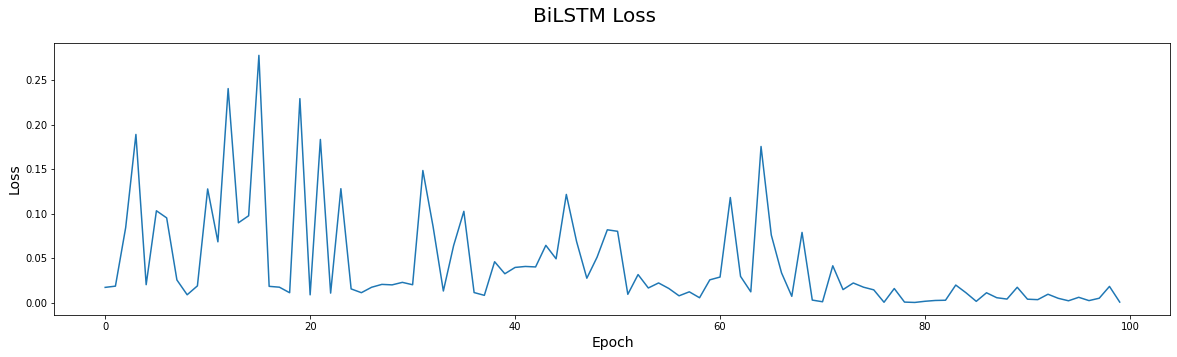

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.patch.set_facecolor('white')
plt.plot(histBiLSTM)
fig.suptitle('BiLSTM Loss',fontsize = 20)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)

####LSTM

Text(0, 0.5, 'Loss')

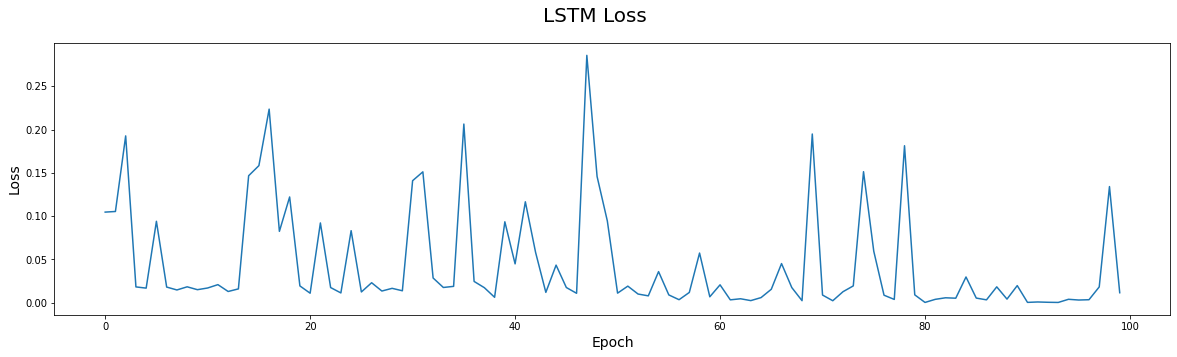

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.patch.set_facecolor('white')
plt.plot(histLSTM)
fig.suptitle('LSTM Loss',fontsize = 20)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)

####RNN

Text(0, 0.5, 'Loss')

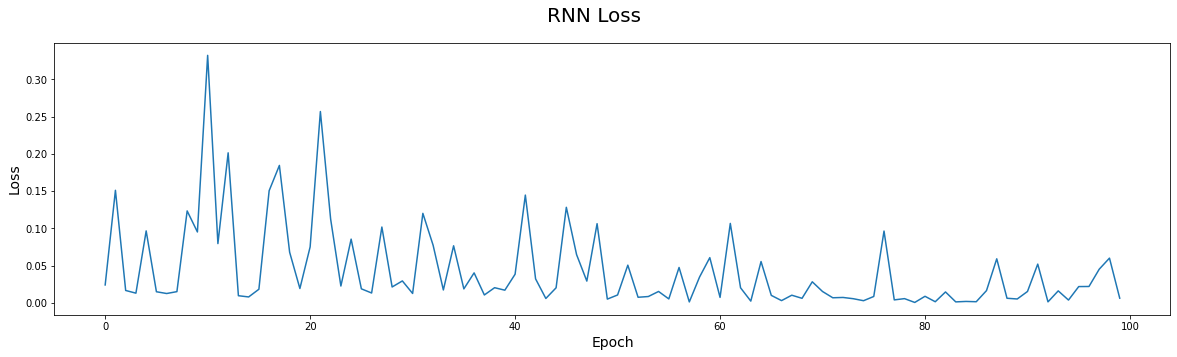

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.patch.set_facecolor('white')
plt.plot(histRNN)
fig.suptitle('RNN Loss',fontsize = 20)
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)

###KFold

In [ ]:
def trainKFoldDL(model,dataloader,loss_fn,optimizer):
  for x_train,y_train in dataloader:
    output = model(x_train)
    output = output.squeeze(1)
    output = output.float()
    loss = criterion(output,y_train)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    return loss.item()

def testKFoldDL(model,dataloader,threshold):
  model.eval()
  y_pred = []
  y_true = []
  with torch.no_grad():
    for x_test,y_test in dataloader:
      predicted = model(x_test)
      predicted = (predicted > threshold).int()
      y_pred.extend(predicted.tolist())
      y_true.extend(y_test.tolist())
  conf_matrix = confusion_matrix(y_true, y_pred, labels=[0,1])
  return conf_matrix

def measurementKFoldDL(conf_matrix_list_of_arrays):
  acc = 0
  recall = 0
  precision = 0
  f1 = 0
  for result in conf_matrix_list_of_arrays:
    tn=result[0][0]
    tp=result[1][1]
    fp=result[0][1]
    fn=result[1][0]
    acc += (tp+tn)/(tn+tp+fp+fn)
    recall += tp/(tp+fn)
    rec = tp/(tp+fn)
    precision += tp/(tp+fp)
    prec = tp/(tp+fp)
    f1 += 2 * (prec * rec) / (prec + rec)
  acc = acc/len(conf_matrix_list_of_arrays)
  recall = recall/len(conf_matrix_list_of_arrays)
  precision = precision/len(conf_matrix_list_of_arrays)
  f1 = f1/len(conf_matrix_list_of_arrays)
  return acc, recall, precision, f1

def KFoldDL(model, tokenized_seqs, tokenized_labels, num_epochs, criterion, threshold=0.5, k=5):
  splits=KFold(n_splits=k,shuffle=True,random_state=42)
  X = tokenized_seqs
  y = tokenized_labels
  data = dataset(X,y)
  threshold = 0.5
  conf_matrix_list_of_arrays = []
  for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(data)))):
    
      model = model
      optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

      train_sampler = SubsetRandomSampler(train_idx)
      test_sampler = SubsetRandomSampler(val_idx)
      train_loader = DataLoader(data, batch_size=1, sampler=train_sampler)
      test_loader = DataLoader(data, batch_size=1, sampler=test_sampler)
      
      history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

      for epoch in range(num_epochs):
          loss = trainKFoldDL(model,train_loader,criterion,optimiser)
      
      conf_matrix = testKFoldDL(model,test_loader,threshold)
      conf_matrix_list_of_arrays.append(conf_matrix)
  acc, recall, precision, f1 = measurementKFoldDL(conf_matrix_list_of_arrays)
  return acc, recall, precision, f1

In [ ]:
with pd.ExcelWriter('outputKFold.xlsx') as writer:
  for file in files:
    measurementList = list()
    drugnames = " "
    drug = file.split('.')[0]
    drug = drug.split('_')
    drug.pop(0)
    drugnames = drugnames.join(drug)
    drugnames = drugnames.title()
    tokenized_seqs, voc2ind, tokenized_labels, train_dataloader, test_dataloader = preprocess(file)
    feature = tokenized_seqs.shape[1]
    num_epochs = 100
    criterion = torch.nn.BCELoss(reduction='mean')
    modelList = [BiLSTM(vocab_size = len(voc2ind),input_dim=feature, hidden_dim=8, output_dim=1, num_layers=1),
                LSTM(vocab_size = len(voc2ind),input_dim=feature, hidden_dim=8, output_dim=1, num_layers=1),
                RNN(vocab_size = len(voc2ind),input_dim=feature, hidden_dim=8, output_dim=1, num_layers=1)]
    for model in modelList:
      start = datetime.now()
      modelName = model.__class__.__name__
      optimiser = torch.optim.SGD(model.parameters(), lr=0.01)
      acc, recall, precision, f1 = KFoldDL(model, tokenized_seqs, tokenized_labels, num_epochs, criterion)
      end = datetime.now()
      computational_time = end - start
      computational_time = computational_time.total_seconds()
      computational_time = computational_time / 60
      measurementList.append([modelName, acc, recall, precision, f1,computational_time])
    dfMeasurement = pd.DataFrame(measurementList,columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'Computational Time (Minutes)'])
    dfMeasurement.to_excel(writer, sheet_name = drugnames, index=False)

#Machine Learning

##Execute

###Non KFold

In [ ]:
def measurementML(conf_matrix):
  tn=conf_matrix[0][0]
  tp=conf_matrix[1][1]
  fp=conf_matrix[0][1]
  fn=conf_matrix[1][0]
  acc = (tp+tn)/(tn+tp+fp+fn)
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  f1 = 2 * (precision * recall) / (precision + recall)
  return acc, recall, precision, f1

def Execute(model, x_train, y_train, x_test, y_test):
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)
  conf_matrix = confusion_matrix(y_test, y_pred,labels = [0,1])
  acc, recall, precision, f1 = measurementML(conf_matrix)
  return acc, recall, precision, f1

In [ ]:
book = load_workbook('output.xlsx')
with pd.ExcelWriter('output.xlsx') as writer:
  writer.book = book
  writer.sheets = {ws.title: ws for ws in book.worksheets}
  for file in files:
    measurementList = list()
    drugnames = " "
    drug = file.split('.')[0]
    drug = drug.split('_')
    drug.pop(0)
    drugnames = drugnames.join(drug)
    drugnames = drugnames.title()
    tokenized_seqs, voc2ind, tokenized_labels, train_dataloader, test_dataloader = preprocess(file)
    X = tokenized_seqs
    y = tokenized_labels
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    model_ML_List = [DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=3), GaussianNB(),
                 svm.SVC(), RandomForestClassifier()]
    for model in model_ML_List:
      start = datetime.now()
      modelName = type(model).__name__
      acc, recall, precision, f1 = Execute(model, x_train, y_train, x_test, y_test)
      end = datetime.now()
      computational_time = end - start
      computational_time = computational_time.total_seconds()
      computational_time = computational_time / 60
      measurementList.append([modelName, acc, recall, precision, f1,computational_time])
    dfMeasurement = pd.DataFrame(measurementList,columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'Computational Time (Minutes)'])
    dfMeasurement.to_excel(writer, sheet_name = drugnames, startrow = writer.sheets[drugnames].max_row, index=False, header=False)

###X_Train, X_Test, Y_Train, Y_Test to Excel

In [ ]:
dfTrain = pd.DataFrame(x_train)
m = dfTrain.select_dtypes(np.number)
dfTrain[m.columns]= m.round().astype('Int64')
# dfTrain['Feature'] = dfTrain[dfTrain.columns[:]].apply(
#     lambda x: ','.join(x.astype(str)),
#     axis=1
# )
# dfTrain = dfTrain[['Feature']]
dfTrain['Class'] = pd.Series(y_train)

In [ ]:
dfTest = pd.DataFrame(x_test)
m = dfTest.select_dtypes(np.number)
dfTest[m.columns]= m.round().astype('Int64')
# dfTest['Feature'] = dfTest[dfTest.columns[:]].apply(
#     lambda x: ','.join(x.astype(str)),
#     axis=1
# )
# dfTest = dfTest[['Feature']]
dfTest['Class'] = pd.Series(y_test)

In [ ]:
dfTrain.to_excel('Data Train Raw.xlsx')
dfTest.to_excel('Data Test Raw.xlsx')

###Plot

####Decision Tree C4.5

In [ ]:
import graphviz 
import pydot
clf = DecisionTreeClassifier()
clf = clf.fit(X, y)
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render(filename='g1.dot')
(graph,) = pydot.graph_from_dot_file('g1.dot')
graph.write_png('Decision Tree C4.5 Plot.png')

####SVM

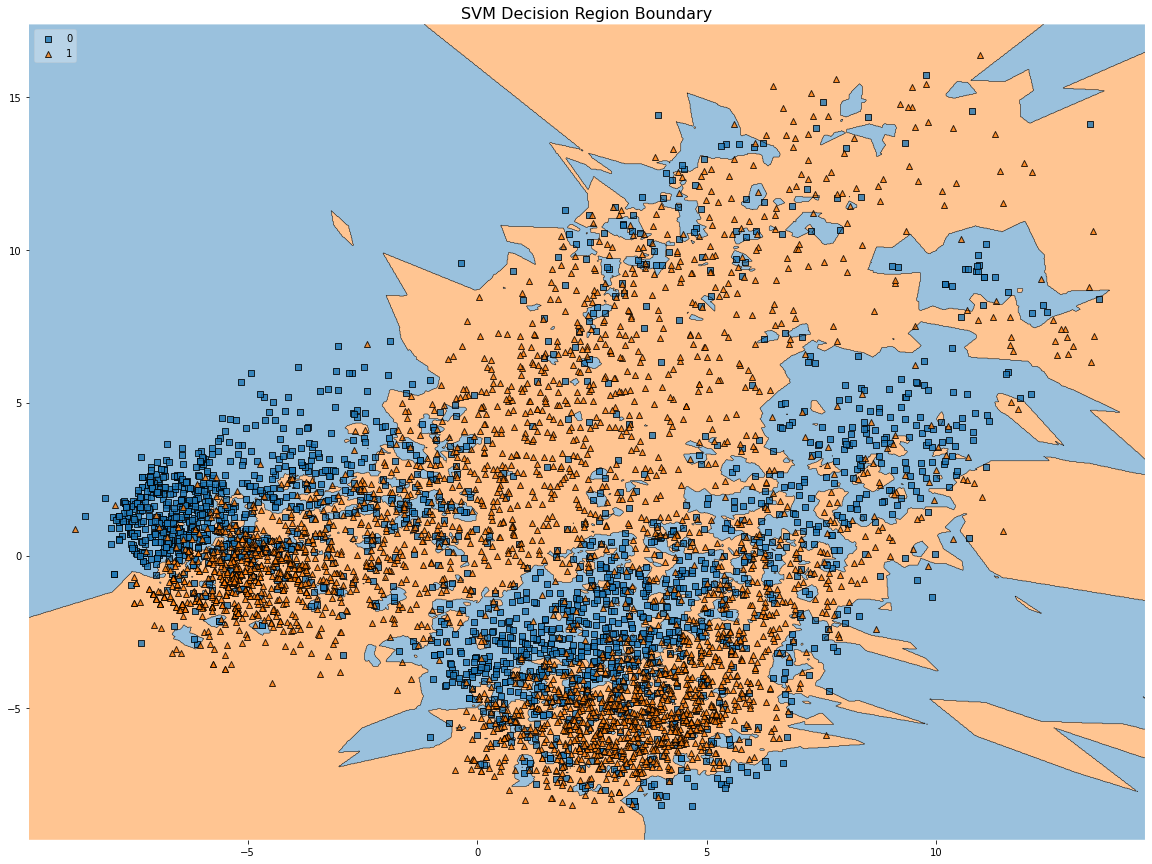

In [ ]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
model = svm.SVC()
y_train = np.array(y_train)
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(x_train)
clf.fit(X_train2, y_train)
fig = plt.figure(figsize=(20,15))
fig.patch.set_facecolor('white')
plot_decision_regions(X_train2, y_train, clf=clf, legend=2)

plt.title('SVM Decision Region Boundary', size=16)
plt.show()

####KNN

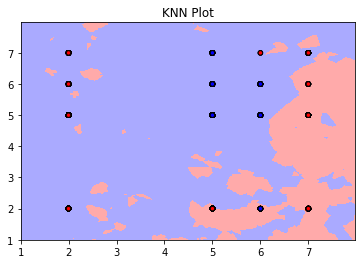

In [ ]:
from matplotlib.colors import ListedColormap
h = .02
clf = KNeighborsClassifier(n_neighbors=3)
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(x_train)
clf.fit(X_train2, y_train)
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold  = ListedColormap(['#FF0000', '#0000FF'])
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)   
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN Plot")
plt.show()

####Random Forest

In [ ]:
clf = RandomForestClassifier()
clf = clf.fit(X, y)
features = dfTrain.loc[:, dfTrain.columns != 'Class']
dot_data = tree.export_graphviz(clf.estimators_[0],
                feature_names=features.columns,
                filled=True,
                rounded=True)
graph = graphviz.Source(dot_data)
graph.render(filename='g1.dot')
(graph,) = pydot.graph_from_dot_file('g1.dot')
graph.write_png('Random Forest Plot.png')

###KFold

In [ ]:
def KFoldML(splits, model, X, y):
  cv = KFold(n_splits=splits, random_state=42, shuffle=True)
  accuracy = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
  mean_accuracy = mean(accuracy)

  scorer = make_scorer(recall_score, pos_label=1)
  recall = cross_val_score(model, X, y, scoring = scorer,cv=cv)
  mean_recall = mean(recall)

  precision = cross_val_score(model, X, y, scoring="precision", cv = cv)
  mean_precision = mean(precision)
  f1 = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
  return acc, mean_recall, mean_precision, f1

In [ ]:
splits = 5
book = load_workbook('outputKFold.xlsx')
with pd.ExcelWriter('outputKFold.xlsx') as writer:
  writer.book = book
  writer.sheets = {ws.title: ws for ws in book.worksheets}
  for file in files:
    measurementList = list()
    drugnames = " "
    drug = file.split('.')[0]
    drug = drug.split('_')
    drug.pop(0)
    drugnames = drugnames.join(drug)
    drugnames = drugnames.title()
    drugnames = drugnames
    tokenized_seqs, voc2ind, tokenized_labels, train_dataloader, test_dataloader = preprocess(file)
    X = tokenized_seqs
    y = tokenized_labels
    model_ML_List = [DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=3), GaussianNB(),
                 svm.SVC(), RandomForestClassifier()]
    for model in model_ML_List:
      start = datetime.now()
      modelName = type(model).__name__
      acc, recall, precision, f1 = KFoldML(splits, model, X, y)
      end = datetime.now()
      computational_time = end - start
      computational_time = computational_time.total_seconds()
      computational_time = computational_time / 60
      measurementList.append([modelName, acc, recall, precision, f1,computational_time])
    dfMeasurement = pd.DataFrame(measurementList,columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'Computational Time (Minutes)'])
    dfMeasurement.to_excel(writer, sheet_name = drugnames, startrow = writer.sheets[drugnames].max_row, index=False, header=False)

#Percobaan Pada BiLSTM

In [ ]:
tokenized_seqs, voc2ind, tokenized_labels, train_dataloader, test_dataloader = preprocess('pf_drug_pyrim.xlsx')
num_epochs = 100
feature = tokenized_seqs.shape[1]
measurementList = list()
for i in range(10):
  start = datetime.now()
  percobaan = "Percobaan Ke " + str((i+1))
  print(percobaan)
  model = BiLSTM(vocab_size = len(voc2ind),input_dim=feature, hidden_dim=32, output_dim=1, num_layers=2)
  criterion = torch.nn.BCELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
  hist = train(num_epochs, train_dataloader, model, criterion, optimiser)
  y_true, y_pred = test(model)
  acc, recall, precision, f1 = measurementDL(y_true, y_pred)
  end = datetime.now()
  computational_time = end - start
  computational_time = computational_time.total_seconds()
  computational_time = computational_time / 60
  measurementList.append([percobaan, acc, recall, precision, f1,computational_time])
dfMeasurementExp = pd.DataFrame(measurementList,columns=['Percobaan', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'Computational Time (Minutes)'])

Percobaan Ke 1
Percobaan Ke 2
Percobaan Ke 3
Percobaan Ke 4
Percobaan Ke 5
Percobaan Ke 6
Percobaan Ke 7
Percobaan Ke 8
Percobaan Ke 9
Percobaan Ke 10


In [ ]:
dfMeasurementExp

,Percobaan,Accuracy,Recall,Precision,F1 Score,Computational Time (Minutes)
0,Percobaan Ke 1,0.984,1.0,0.984,0.991935,0.257843
1,Percobaan Ke 2,0.984,1.0,0.984,0.991935,0.254548
2,Percobaan Ke 3,0.984,1.0,0.984,0.991935,0.292774
3,Percobaan Ke 4,0.984,1.0,0.984,0.991935,0.274446
4,Percobaan Ke 5,0.984,1.0,0.984,0.991935,0.248274
5,Percobaan Ke 6,0.984,1.0,0.984,0.991935,0.250731
6,Percobaan Ke 7,0.984,1.0,0.984,0.991935,0.256927
7,Percobaan Ke 8,0.984,1.0,0.984,0.991935,0.252514
8,Percobaan Ke 9,0.984,1.0,0.984,0.991935,0.251273
9,Percobaan Ke 10,0.984,1.0,0.984,0.991935,0.248352


In [ ]:
dfMeasurementExp.to_excel('Hasil Percobaan 10 Kali Run.xlsx')